Fold 1: Train 134405, Test 33602
Exported fold 1 test set to fold1_test_sequences.csv


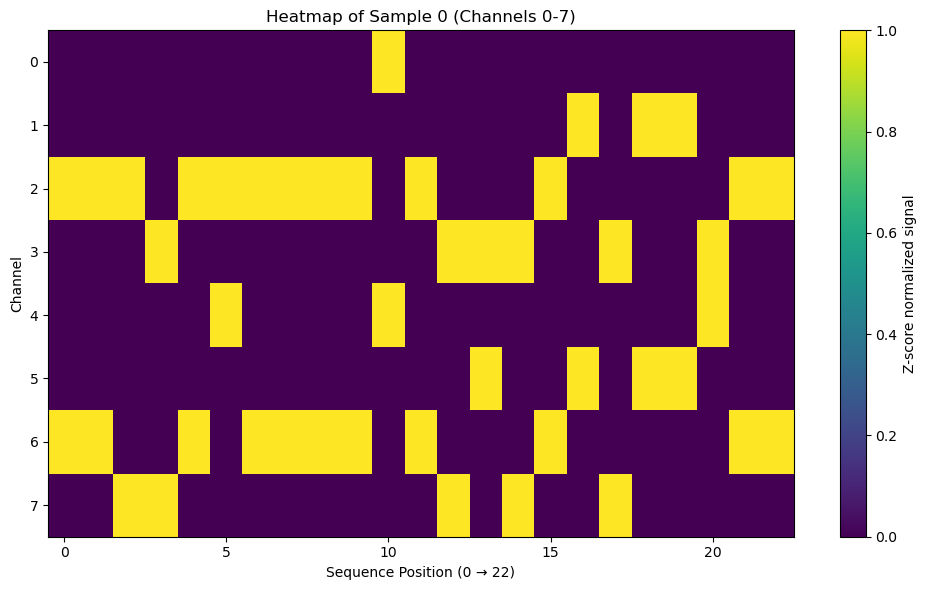

Saved sequence to sequence_sample0.csv
Fold 2: Train 134405, Test 33602
Exported fold 2 test set to fold2_test_sequences.csv
Fold 3: Train 134406, Test 33601
Exported fold 3 test set to fold3_test_sequences.csv
Fold 4: Train 134406, Test 33601
Exported fold 4 test set to fold4_test_sequences.csv
Fold 5: Train 134406, Test 33601
Exported fold 5 test set to fold5_test_sequences.csv


In [6]:
from matplotlib.colors import LogNorm
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

def binary_stratified_random_split(
    X, y, test_ratio=0.2, test_chunk=1, seed=None
):
    if not (0 < test_ratio < 1):
        raise ValueError("test_ratio must be between 0 and 1")
    n_splits = int(1 / test_ratio)
    if not (1 <= test_chunk <= n_splits):
        raise ValueError(f"test_chunk must be in [1, {n_splits}]")
    if seed is not None:
        torch.manual_seed(seed)
    fold_labels = torch.empty(len(y), dtype=torch.long)
    for cls in [0, 1]:
        cls_idx = (y == cls).nonzero(as_tuple=True)[0]
        permuted = cls_idx[torch.randperm(len(cls_idx))]
        base_size = len(permuted) // n_splits
        extras = len(permuted) % n_splits
        start = 0
        for fold in range(n_splits):
            size = base_size + (1 if fold < extras else 0)
            end = start + size
            fold_labels[permuted[start:end]] = fold
            start = end
    fold = test_chunk - 1
    test_idx  = (fold_labels == fold).nonzero(as_tuple=True)[0]
    train_idx = (fold_labels != fold).nonzero(as_tuple=True)[0]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def plot_normalized_heatmap(X, sample_idx=0, channels=range(8)):
    if not isinstance(X, torch.Tensor):
        raise ValueError("Input X must be a torch.Tensor.")
    if sample_idx < 0 or sample_idx >= X.shape[0]:
        raise IndexError(f"Sample index {sample_idx} out of range. Total samples: {X.shape[0]}")
    sample = X[sample_idx, channels, :]
    if sample.requires_grad:
        sample = sample.detach()
    if sample.is_cuda:
        sample = sample.cpu()
    plt.figure(figsize=(10, 6))
    plt.imshow(sample.numpy(), aspect='auto', interpolation='nearest')
    plt.colorbar(label='Z-score normalized signal')
    plt.title(f'Heatmap of Sample {sample_idx} (Channels {channels.start}-{channels.stop-1})')
    plt.xlabel('Sequence Position (0 → 22)')
    plt.ylabel('Channel')
    plt.tight_layout()
    plt.show()

def tensor_to_seq_csv(tensor_sample, label, out_path):
    base_map = ['A', 'C', 'G', 'T']
    seq = ''
    offsite = ''
    for pos in range(tensor_sample.shape[1]):
        sg_base_idx = torch.argmax(tensor_sample[0:4, pos]).item()
        off_base_idx = torch.argmax(tensor_sample[4:8, pos]).item()
        seq += base_map[sg_base_idx]
        offsite += base_map[off_base_idx]
    df = pd.DataFrame({'sgRNA': [seq], 'OffSite': [offsite], 'Label': [label]})
    df.to_csv(out_path, index=False)
    print(f"Saved sequence to {out_path}")

# ====== Save Folded Splits (Sequence Channels Only), Plot, and Convert Example ======
def export_fold_test_sequences(X_test, y_test, fold_id, out_path):
    base_map = ['A', 'C', 'G', 'T']
    records = []
    for i in range(X_test.shape[0]):
        tensor_sample = X_test[i]
        label = y_test[i].item()
        seq = ''
        offsite = ''
        for pos in range(tensor_sample.shape[1]):
            sg_base_idx = torch.argmax(tensor_sample[0:4, pos]).item()
            off_base_idx = torch.argmax(tensor_sample[4:8, pos]).item()
            seq += base_map[sg_base_idx]
            offsite += base_map[off_base_idx]
        records.append({'sgRNA': seq, 'OffSite': offsite, 'Label': label, 'Fold': fold_id})
    df = pd.DataFrame(records)
    df.to_csv(out_path, index=False)
    print(f"Exported fold {fold_id} test set to {out_path}")
path_seq = '.'
combined_positive = torch.load(os.path.join(path_seq, 'Positive.pt')).float()
combined_negative = torch.load(os.path.join(path_seq, 'Negative.pt')).float()
labels_positive = torch.ones(combined_positive.shape[0], dtype=torch.float32)
labels_negative = torch.zeros(combined_negative.shape[0], dtype=torch.float32)
X = torch.cat([combined_positive, combined_negative], dim=0)
y = torch.cat([labels_positive, labels_negative], dim=0)

# Keep only last 8 channels (sequence-related)
X = X[:, -8:, :]

for i in range(5):
    test_chunk_id = i + 1
    X_train, X_test, y_train, y_test = binary_stratified_random_split(
        X, y, test_ratio=0.2, test_chunk=test_chunk_id, seed=42
    )
    torch.save(X_train, f"X_train_fold{test_chunk_id}.pt")
    torch.save(X_test, f"X_test_fold{test_chunk_id}.pt")
    torch.save(y_train, f"y_train_fold{test_chunk_id}.pt")
    torch.save(y_test, f"y_test_fold{test_chunk_id}.pt")
    print(f"Fold {test_chunk_id}: Train {X_train.shape[0]}, Test {X_test.shape[0]}")
    export_fold_test_sequences(X_test, y_test, test_chunk_id, out_path=f"fold{test_chunk_id}_test_sequences.csv")

    if i == 0:
        plot_normalized_heatmap(X_train, sample_idx=0)
        tensor_to_seq_csv(X_train[0], y_train[0].item(), out_path="sequence_sample0.csv")
